In [1]:
# Import the libraries
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# Creat paths for convenience
train_path = '../../Food-5K/data/train'
valid_path = '../../Food-5K/data/test'

In [4]:
# Load all the images as a smaller size
IMAGE_SIZE = [200, 200]

In [5]:
# Useful for getting number of files
train_image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

print(len(train_image_files))
print(len(valid_image_files))

3000
1000


In [6]:
# Useful for getting number of classes
folders = glob(train_path + '/*')
len(folders)

2

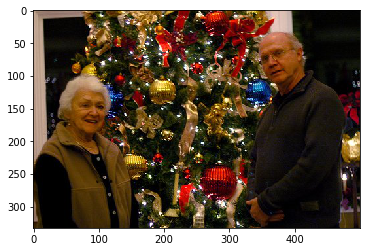

In [7]:
# Load a random image for fun
plt.imshow(image.load_img(np.random.choice(train_image_files)));

In [8]:
ptm = PretrainedModel(input_shape=IMAGE_SIZE + [3], # 3 for the number of color channels
                      weights='imagenet', # need to specify or the weights will be initialized randomly
                      include_top=False) # specifies that we only want the convlution layer and not the dense layers

In [9]:
# Freeze pretrained model weights
ptm.trainable = False

In [10]:
# Map the data into feature vectors
# Keras image data generator returns one-hot encoded classes
K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [11]:
# Create a model object
model = Model(inputs=ptm.input, outputs=x)

In [12]:
# View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [13]:
# Create instance of the ImageDataGenerator
gen = ImageDataGenerator(rotation_range=20,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         preprocessing_function=preprocess_input)

In [14]:
# Define batch size
batch_size = 64

# Create train generator
train_generator = gen.flow_from_directory(train_path,
                                          shuffle=True,
                                          target_size=IMAGE_SIZE,
                                          batch_size=batch_size)

Found 3000 images belonging to 2 classes.


In [15]:
# Create valid generator
valid_generator = gen.flow_from_directory(valid_path,
                                          shuffle=True,
                                          target_size=IMAGE_SIZE,
                                          batch_size=batch_size)

Found 1000 images belonging to 2 classes.


In [16]:
# Define how the model should be trained
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# Train the model
result = model.fit_generator(train_generator,
                             validation_data=valid_generator,
                             epochs=10,
                             steps_per_epoch=int(np.ceil(len(train_image_files) / batch_size)),
                             validation_steps=int(np.ceil(len(valid_image_files) / batch_size)))

Epoch 1/10
47/47 [==============================] - 88s 2s/step - loss: 0.6842 - accuracy: 0.9433 - val_loss: 0.4533 - val_accuracy: 0.9650
Epoch 2/10
47/47 [==============================] - 71s 2s/step - loss: 0.4138 - accuracy: 0.9680 - val_loss: 0.4450 - val_accuracy: 0.9620
Epoch 3/10
47/47 [==============================] - 73s 2s/step - loss: 0.3589 - accuracy: 0.9720 - val_loss: 0.5963 - val_accuracy: 0.9550
Epoch 4/10
47/47 [==============================] - 74s 2s/step - loss: 0.3327 - accuracy: 0.9760 - val_loss: 0.4653 - val_accuracy: 0.9640
Epoch 5/10
47/47 [==============================] - 72s 2s/step - loss: 0.2826 - accuracy: 0.9787 - val_loss: 0.5666 - val_accuracy: 0.9580
Epoch 6/10
47/47 [==============================] - 73s 2s/step - loss: 0.3769 - accuracy: 0.9727 - val_loss: 0.5075 - val_accuracy: 0.9670
Epoch 7/10
47/47 [==============================] - 74s 2s/step - loss: 0.2557 - accuracy: 0.9817 - val_loss: 0.3136 - val_accuracy: 0.9730
Epoch 8/10
47/47 [==

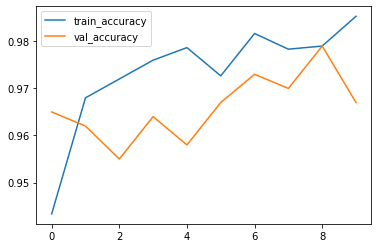

In [18]:
# Plot the cost function at each itteration
plt.plot(result.history['accuracy'], label='train_accuracy');
plt.plot(result.history['val_accuracy'], label='val_accuracy');
plt.legend();